In [1]:
import os, sys, re, datetime, shutil
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.table import Table
LTE_calc_path = os.path.join(os.path.dirname(os.getcwd()), 'tmp', 'calc_LTE_R_CI10CO21')
radex_calc_path = os.path.join(os.path.dirname(os.getcwd()), 'tmp', 'calc_radex_disky') # 'calc_radex'

def list2str(inlist, format_str = '{}'):
    return '[' + ', '.join([format_str.format(t) for t in inlist]) + ']'


In [2]:
# User-defined global parameters

list_of_X_CICO = np.logspace(np.log10(0.01), np.log10(8.00), num=150, endpoint=True)

#list_of_N_CO = 10**np.arange(17.0, 20.0+0.125, 0.125)
list_of_N_CO = 10**np.arange(17.0, 19.5+0.125, 0.125)

list_of_T_kin_for_N_repISM = np.array([15., 20., 25., 50., 50., 100., 100.]) # T_kin in K
list_of_d_V_for_N_repISM = np.array([3., 10., 25., 50., 40., 70., 90.]) # d_V in km/s
list_of_CO_abundance_for_N_repISM = np.array([1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4]) # [CO/H2]
list_of_text_label_for_N_repISM = ['Galactic clouds', # Solomon+87,Heyer13
                                   'NGC3627 SF disk',
                                   'NGC3627 SF bar-ends',
                                   'NGC1808/7469 SB disk',
                                   'NGC4321 LINER nuc',
                                   'NGC3627 low AGN nuc',
                                   'NGC7469 AGN nuc']
list_of_I_CO10_range_for_N_repISM = [
    (30.,50.), (100.,200.), (350.,500.), (800.,1000.), 
    (700.,1000.), (1000.,1400.), (2000.,2200.) ] # K km s-1 for representative ISM conditions

list_of_I_CO10_for_N_repISM = np.array([
    np.array(list(t)).mean() for t in list_of_I_CO10_range_for_N_repISM ])

list_of_Sigma_mol_for_N_repISM = np.array([
        140.0, # Inner Galactic GMC, from Roman-Duval et al. (2010), MW BU-FCRAO GRS of 13CO
        300.0, # NGC3627 disk GMC, value by my guessing.
               # Note that Watanabe et al. (2019), NGC3627 Spiral Arm 20K NCO 2.1e17, 
               # Bar End 20K NCO 3.7e17, Nucleus 20K NCO 5.8e17, but [CO/H2] ~ 1e-5
        400.0, # NGC3627 bar end, value by my guessing.
        800.0, # NGC1808 SB disk, value by my guessing.
        10**2.94, # NGC4321 center, from Sun et al. (2018) Fig. 1, assumed metalZ-dependent alphaCO
        10**2.971, # NGC3627 center, from Sun et al. (2018) Fig. 1, assumed metalZ-dependent alphaCO
        1500.0, # NGC7469 center, value by my guessing.
    ]) # with helium
list_of_Sigma_H2_for_N_repISM = list_of_Sigma_mol_for_N_repISM / 1.36 # no helium
list_of_alphaCO10_for_N_repISM = list_of_Sigma_mol_for_N_repISM / list_of_I_CO10_for_N_repISM # with helium
list_of_N_H2_for_N_repISM = list_of_Sigma_H2_for_N_repISM * 0.624e20

print('list_of_alphaCO10_for_N_repISM', list2str(list_of_alphaCO10_for_N_repISM, '{:.3f}'))
print('list_of_Sigma_H2_for_N_repISM', list2str(list_of_Sigma_H2_for_N_repISM, '{:.3f}'))
print('list_of_Sigma_mol_for_N_repISM', list2str(list_of_Sigma_mol_for_N_repISM, '{:.3f}'))
print('list_of_N_H2_for_N_repISM', list2str(list_of_N_H2_for_N_repISM, '{:.3e}'))

list_of_Sigma_mol_range_for_N_repISM = np.array([
    (t[0]*a, t[1]*a) for t, a in list(zip(list_of_I_CO10_range_for_N_repISM, list_of_alphaCO10_for_N_repISM))
])
print('list_of_Sigma_mol_range_for_N_repISM', list_of_Sigma_mol_range_for_N_repISM)

list_of_R_CI10CO21_for_N_repISM = [0.1, 0.1, 0.1, 0.2, 0.06, 0.1, 0.5]

out_fig_size = [14.5, 5.8]

out_fig_margin = dict(left=0.065, right=0.95, bottom=0.10, top=0.73)

overwrite_calc = False # True # False # redo calc if 'list_of_X_CICO' changed!


list_of_alphaCO10_for_N_repISM [3.500, 2.000, 0.941, 0.889, 1.025, 0.780, 0.714]
list_of_Sigma_H2_for_N_repISM [102.941, 220.588, 294.118, 588.235, 640.414, 687.798, 1102.941]
list_of_Sigma_mol_for_N_repISM [140.000, 300.000, 400.000, 800.000, 870.964, 935.406, 1500.000]
list_of_N_H2_for_N_repISM [6.424e+21, 1.376e+22, 1.835e+22, 3.671e+22, 3.996e+22, 4.292e+22, 6.882e+22]
list_of_Sigma_mol_range_for_N_repISM [[ 105.          175.        ]
 [ 200.          400.        ]
 [ 329.41176471  470.58823529]
 [ 711.11111111  888.88888889]
 [ 717.26413291 1024.66304701]
 [ 779.50472846 1091.30661984]
 [1428.57142857 1571.42857143]]


In [3]:
CO = {}
CO['Einstein_A'] = np.array([
    7.203e-08, 6.910e-07, 2.497e-06, 6.126e-06, 1.221e-05, 2.137e-05, 3.422e-05, 5.134e-05, 7.330e-05, 1.006e-04, 
    1.339e-04, 1.735e-04, 2.200e-04, 2.739e-04, 3.354e-04, 4.050e-04, 4.829e-04, 5.695e-04, 6.650e-04, 7.695e-04, 
    8.833e-04, 1.006e-03, 1.139e-03, 1.281e-03, 1.432e-03, 1.592e-03, 1.761e-03, 1.940e-03, 2.126e-03, 2.321e-03, 
    2.524e-03, 2.735e-03, 2.952e-03, 3.175e-03, 3.404e-03, 3.638e-03, 3.878e-03, 4.120e-03, 4.365e-03, 4.613e-03, 
])
CO['E_u'] = np.array([
    5.53,      16.60,   33.19,   55.32,   82.97,  116.16,  154.87,  199.11,  248.88, 304.16, 
    364.97,   431.29,  503.13,  580.49,  663.35,  751.72,  845.59,  944.97, 1049.84, 1160.20, 
    1276.05, 1397.38, 1524.19, 1656.47, 1794.23, 1937.44, 2086.12, 2240.24, 2399.82, 2564.83, 
    2735.28, 2911.15, 3092.45, 3279.15, 3471.27, 3668.78, 3871.69, 4079.98, 4293.64, 4512.67, 
])
CO['nu'] = np.array([
     115.2712018,  230.5380000,  345.7959899,  461.0407682,  576.2679305, 
     691.4730763,  806.6518060,  921.7997000, 1036.9123930, 1151.9854520, 
    1267.0144860, 1381.9951050, 1496.9229090, 1611.7935180, 1726.6025057, 
    1841.3455060, 1956.0181390, 2070.6159930, 2185.1346800, 2299.5698420, 
    2413.9171130, 2528.1720600, 2642.3303459, 2756.3875840, 2870.3394070, 
    2984.1814550, 3097.9093610, 3211.5187506, 3325.0052827, 3438.3646110, 
    3551.5923610, 3664.6841800, 3777.6357280, 3890.4427170, 4003.1007876, 
    4115.6055850, 4227.9527744, 4340.1381120, 4452.1571221, 4564.0056399, 
])

In [4]:
CI = {}
CI['Einstein_A'] = np.array([
    7.880E-08, 2.650E-07, 
    #1.810E-14, 
])
CI['E_u'] = np.array([
    23.620, 62.462, 
    # 62.462, 
])
CI['nu'] = np.array([
    492.160651, 809.34197, 
    # 1301.50262, 
])

In [5]:
def calc_Q(E_u, T_kin, N=None):
    E_j = np.concatenate([[0.0], E_u])
    if N is None:
        N = len(E_j)
    j = np.arange(N)
    E_j = E_j[0:N]
    #E_j = (j*(j+1)) * E_u[0]
    return np.sum(1.0 * (j+(j+1)) * np.exp(-1.0 * E_j / T_kin))

In [6]:
def calc_Bnu(
        nu, 
        T_ex, 
    ):
    c = const.c.cgs.value # 2.99792458e+10 cm / s
    pi = np.pi
    h = const.h.cgs.value # 6.62607015e-27 erg s
    k = const.k_B.cgs.value # 1.380649e-16 erg / K
    hnu_kt = h*(nu*1e9)/(k*T_ex)
    Bnu = 2*h*(nu*1e9)**3/c**2 * (1.0 / (np.exp(hnu_kt) - 1.0))
    return Bnu

def calc_Bnu_CI10(T_ex):
    global CI
    j_u = 1
    j_l = 0
    idx_trans = 0
    return calc_Bnu(
        nu = CI['nu'][idx_trans], 
        T_ex = T_ex, 
    )

def calc_Bnu_CO21(T_ex):
    global CO
    j_u = 2
    j_l = 1
    idx_trans = 1
    return calc_Bnu(
        nu = CO['nu'][idx_trans], 
        T_ex = T_ex, 
    )

def calc_tau(
        nu, 
        g_u, 
        Q, 
        A_ul, 
        N_dV, 
        T_ex, 
    ):
    c = const.c.cgs.value # 2.99792458e+10 cm / s
    pi = np.pi
    h = const.h.cgs.value # 6.62607015e-27 erg s
    k = const.k_B.cgs.value # 1.380649e-16 erg / K
    hnu_kt = h*(nu*1e9)/(k*T_ex)
    #print('nu', nu)
    #print('Q', Q)
    #print('c**3/(8.0*pi*(nu*1e9)**3)', c**3/(8.0*pi*(nu*1e9)**3))
    #print('hnu_kt', hnu_kt)
    N_dV_cm_2_km_s_1 = N_dV # input should have a unit of cm^{-2} (km s^{-1})^{-1}
    N_dV_cm_2_cm_s_1 = N_dV_cm_2_km_s_1 / 1e5 # km^{-1} to cm^{-1}
    return c**3/(8.0*pi*(nu*1e9)**3) * (g_u/Q) * A_ul * N_dV_cm_2_cm_s_1 / 1.0645 * (1.0 - np.exp( -hnu_kt ))

def calc_tau_CI10(N_dV, T_ex):
    global CI
    j_u = 1
    j_l = 0
    idx_trans = 0
    return calc_tau(
        nu = CI['nu'][idx_trans], 
        g_u = 2*j_u+1, 
        Q = calc_Q(CI['E_u'], T_ex), 
        A_ul = CI['Einstein_A'][idx_trans],
        N_dV = N_dV, 
        T_ex = T_ex, 
    )

def calc_tau_CO21(N_dV, T_ex):
    global CO
    j_u = 2
    j_l = 1
    idx_trans = 1
    return calc_tau(
        nu = CO['nu'][idx_trans], 
        g_u = 2*j_u+1, 
        Q = calc_Q(CO['E_u'], T_ex), 
        A_ul = CO['Einstein_A'][idx_trans],
        N_dV = N_dV, 
        T_ex = T_ex, 
    )


In [7]:
def calc_LTE_R_CI10CO21(
        N_CO, 
        d_V, 
        T_kin, 
        T_CMB = 2.73, 
        verbose = True,
        overwrite = False, 
    ):
    #
    global list_of_X_CICO
    global LTE_calc_path
    global CO
    global CI
    #
    list_of_R_CI10CO21 = np.zeros(len(list_of_X_CICO))
    N_CO_str = '{:.2e}'.format(N_CO).replace('e+','e')
    d_V_str = '{:.0f}'.format(d_V)
    T_kin_str = '{:.0f}'.format(T_kin)
    out_table_dict = {'N_CO': [], 'N_CI': [], 'X_CICO': [], 'line_width': [], 'T_kin': [], 
                      'tau_CI10': [], 'tau_CO21': [], 'omexpm_tau_CI10': [], 'omexpm_tau_CO21': [], 
                      'R_CI10CO21': []}
    out_table_name = f'out_table_LTE_R_CI10CO21_N_CO_{N_CO_str}_dV_{d_V_str}_T_kin_{T_kin_str}.csv'
    out_table_file = os.path.join(LTE_calc_path, out_table_name)
    if not os.path.isdir(LTE_calc_path):
        os.makedirs(LTE_calc_path)
    if not os.path.isdir(LTE_calc_path):
        raise Exception('Error! Could not create dir: ' + LTE_calc_path)
    
    if os.path.isfile(out_table_file) and not overwrite:
        print(f'Found "{out_table_file}". Returning.')
        return
    
    nu_CI10 = CI['nu'][0]
    nu_CO21 = CO['nu'][1]
    for i in range(len(list_of_X_CICO)):
        X_CICO = list_of_X_CICO[i]

        tau_CI10 = calc_tau_CI10(N_dV = X_CICO*N_CO/d_V, T_ex = T_kin)
        tau_CO21 = calc_tau_CO21(N_dV = N_CO/d_V, T_ex = T_kin)

        omexpm_tau_CI10 = 1.0 - np.exp(-tau_CI10)
        omexpm_tau_CO21 = 1.0 - np.exp(-tau_CO21)
        R_ometau_CI10CO21 = omexpm_tau_CI10 / omexpm_tau_CO21
        
        Bnu_CI10 = calc_Bnu_CI10(T_ex = T_kin)
        Bnu_CO21 = calc_Bnu_CO21(T_ex = T_kin)
        Bnu_TCMB_CI10 = calc_Bnu_CI10(T_ex = T_CMB)
        Bnu_TCMB_CO21 = calc_Bnu_CO21(T_ex = T_CMB)
        
        R_Bnu_CI10CO21 = (Bnu_CI10 - Bnu_TCMB_CI10) / (Bnu_CO21 - Bnu_TCMB_CO21)
        
        R_CI10CO21 = nu_CI10**(-2) / nu_CO21**(-2) * R_ometau_CI10CO21 * R_Bnu_CI10CO21
        
        list_of_R_CI10CO21[i] = R_CI10CO21
    
        if verbose:
            print('i', i+1, '/', len(list_of_X_CICO))
            print('tau_CI10', tau_CI10)
            print('tau_CO21', tau_CO21)
            print('1-e^-tau_CI10', omexpm_tau_CI10)
            print('1-e^-tau_CO21', omexpm_tau_CO21)
            print('(1-e^-tau_CI10)/(1-e^-tau_CO21)', R_ometau_CI10CO21)
            print('Bnu(CI10)', Bnu_CI10)
            print('Bnu(CO21)', Bnu_CO21)
            print('(Bnu(CI10)-Bnu(TCMB))/(Bnu(CO21)-Bnu(TCMB))', R_Bnu_CI10CO21)
            print('R_CI10CO21', R_CI10CO21)

        out_table_dict['N_CO'].append(N_CO)
        out_table_dict['N_CI'].append(X_CICO*N_CO)
        out_table_dict['X_CICO'].append(X_CICO)
        out_table_dict['line_width'].append(d_V)
        out_table_dict['T_kin'].append(T_kin)
        out_table_dict['tau_CI10'].append(tau_CI10)
        out_table_dict['tau_CO21'].append(tau_CO21)
        out_table_dict['omexpm_tau_CI10'].append(omexpm_tau_CI10)
        out_table_dict['omexpm_tau_CO21'].append(omexpm_tau_CO21)
        out_table_dict['R_CI10CO21'].append(R_CI10CO21)

    out_table = Table(out_table_dict)
    out_table.write(out_table_file, format='csv', overwrite=overwrite)
    print(f'Output to "{out_table_file}"')
    
    
    
# Call the function for a list of N_CO and T_kin

if __name__ == '__main__' and '__file__' not in globals():
    
    verbose = True
    for N_CO in list_of_N_CO:
        for T_kin, d_V in list(zip(list_of_T_kin_for_N_repISM, list_of_d_V_for_N_repISM)):
            calc_LTE_R_CI10CO21(
                N_CO = N_CO,
                d_V = d_V,
                T_kin = T_kin,
                verbose = verbose,
                overwrite = overwrite_calc, 
            )
            verbose = False # first iteration is verbose, others are non-verbose.


Found "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/tmp/calc_LTE_R_CI10CO21/out_table_LTE_R_CI10CO21_N_CO_1.00e17_dV_3_T_kin_15.csv". Returning.
Found "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/tmp/calc_LTE_R_CI10CO21/out_table_LTE_R_CI10CO21_N_CO_1.00e17_dV_10_T_kin_20.csv". Returning.
Found "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/tmp/calc_LTE_R_CI10CO21/out_table_LTE_R_CI10CO21_N_CO_1.00e17_dV_25_T_kin_25.csv". Returning.
Found "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/tmp/calc_LTE_R_CI10CO21/out_table_LTE_R_CI10CO21_N_CO_1.00e17_dV_50_T_kin_50.csv". Returning.
Found "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/tmp/calc_LTE_R_CI10CO21/out_table_LTE_R_CI10CO21_N_CO_1.00e17_dV_40_T_kin_50.csv". Returning.
Found "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/tmp/calc_LTE_R_CI10CO21/out_table_LTE_R_CI10CO21_N_CO_1.00e17_dV_70_T_kin_100.csv

In [8]:
# Define function to read x y from table

def read_X_CICO_R_CICO_from_table(
        N_CO, 
        d_V, 
        T_kin, 
        n_H2 = None, 
        LTE = True,
    ):
    N_CO_str = '{:.2e}'.format(N_CO).replace('e+','e')
    d_V_str = '{:.0f}'.format(d_V)
    T_kin_str = '{:.0f}'.format(T_kin)
    in_table_name = f'out_table_LTE_R_CI10CO21_N_CO_{N_CO_str}_dV_{d_V_str}_T_kin_{T_kin_str}.csv'
    in_table_file = os.path.join(LTE_calc_path, in_table_name)
    in_table = Table.read(in_table_file, format='csv')
    
    x = in_table['X_CICO']
    y = in_table['R_CI10CO21']
    mask_CO_opt_thin = in_table['tau_CO21']<1.
    mask_CI_opt_thin = in_table['tau_CI10']<1.
    
    return x, y, mask_CO_opt_thin, mask_CI_opt_thin


vmin 17.3, vmax 19.0
--
panel 1, CO_abundance 1.0e-04, R_CI10CO21 0.1, I_CO10_range (30.0, 50.0), alphaCO10 3.50, 
Sigma_mol_range [105. 175.] vs. right axis y range [  21.78 6887.21]
highlight_N_CO_range_log10 [17.68 17.9 ] highlight_N_CO_mean_log10 17.81 vs. left axis y range [17.  19.5]
highlight_line_color (0.0, 0.3697783461210571, 1.0, 1.0)
highlight_x1 0.08, highlight_x2 0.11, highlight_y1 17.89, highlight_y2 17.69, highlight_ry1 167.6, highlight_ry2 105.6
--
panel 2, CO_abundance 1.0e-04, R_CI10CO21 0.1, I_CO10_range (100.0, 200.0), alphaCO10 2.00, 
Sigma_mol_range [200. 400.] vs. right axis y range [  21.78 6887.21]
highlight_N_CO_range_log10 [17.96 18.26] highlight_N_CO_mean_log10 18.14 vs. left axis y range [17.  19.5]
highlight_line_color (0.0, 1.0, 0.5692599620493359, 1.0)
highlight_x1 0.14, highlight_x2 0.25, highlight_y1 18.23, highlight_y2 17.97, highlight_ry1 369.1, highlight_ry2 203.2
--
panel 3, CO_abundance 1.0e-04, R_CI10CO21 0.1, I_CO10_range (350.0, 500.0), alphaC

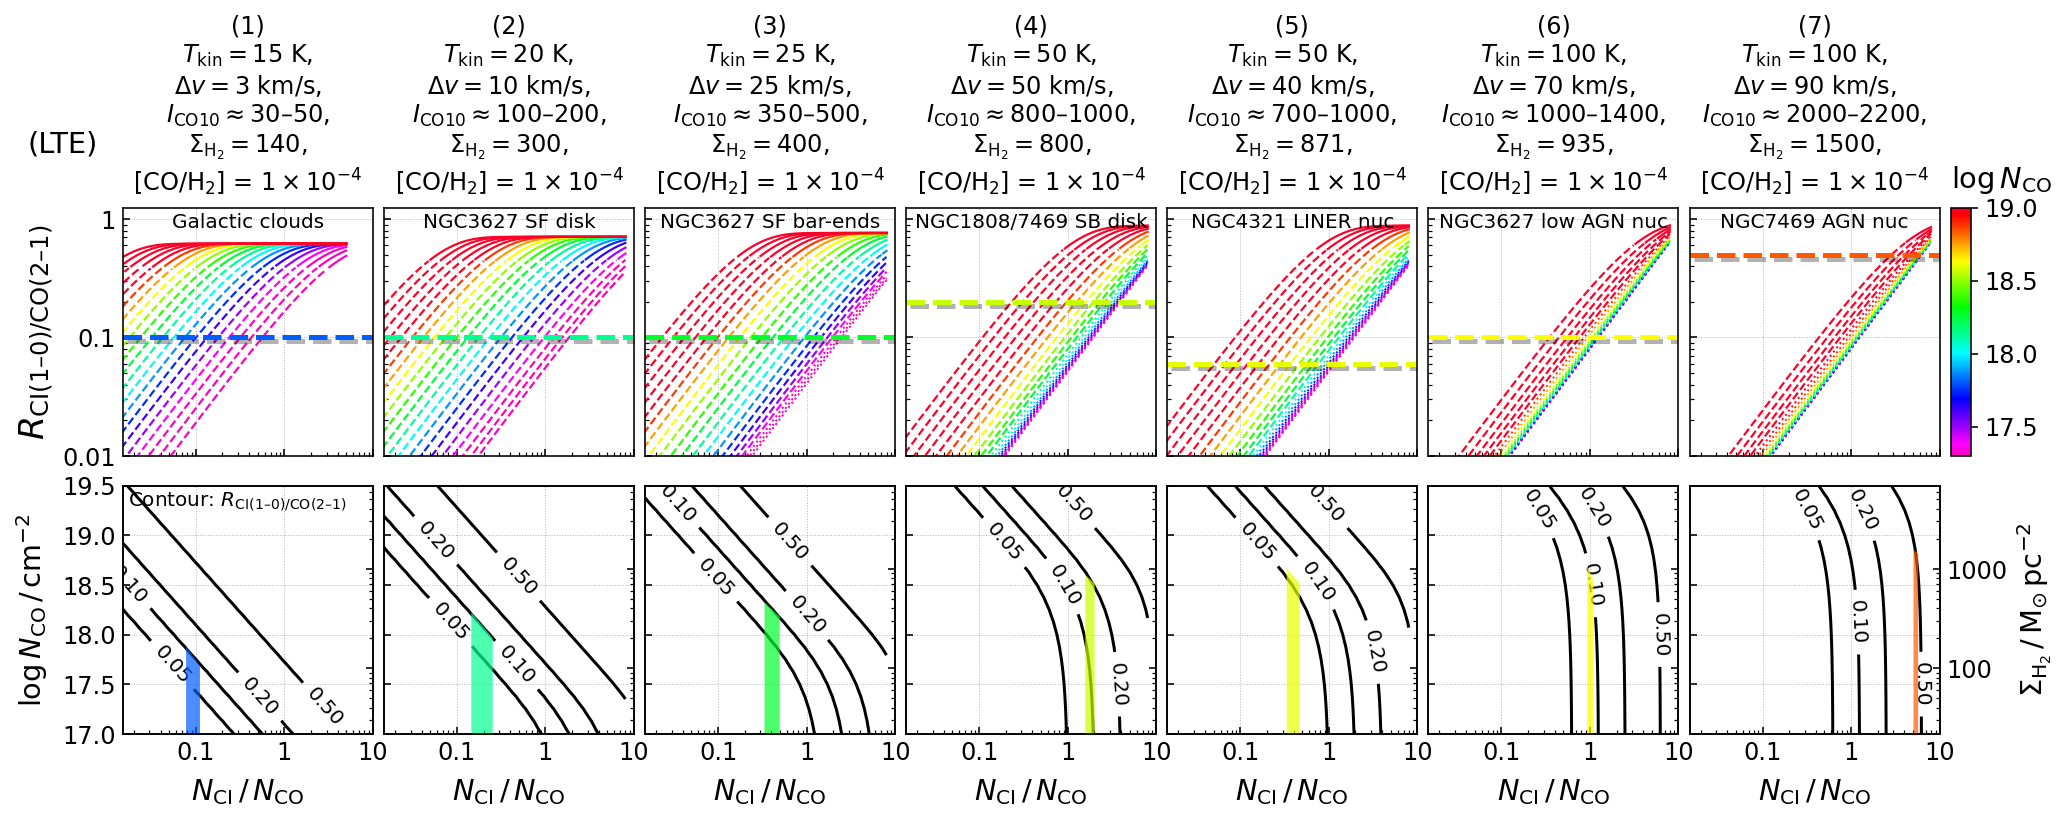

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import ticker
import matplotlib.patheffects as path_effects
from scipy.interpolate import interp2d


def make_a_figure(
        out_figure_file, 
        n_H2 = None, 
        list_of_n_H2 = None, 
        LTE = True, 
        xlim = [0.015, 10.00], 
        ylim = [0.01, 1.25], 
    ):
    # 
    global list_of_X_CICO
    global list_of_N_CO 
    global list_of_T_kin_for_N_repISM
    global list_of_d_V_for_N_repISM 
    global list_of_CO_abundance_for_N_repISM
    global list_of_text_label_for_N_repISM
    global list_of_I_CO10_range_for_N_repISM
    global list_of_Sigma_mol_for_N_repISM
    global list_of_Sigma_mol_range_for_N_repISM
    # 
    minima = np.nan
    maxima = np.nan
    fig = plt.figure(figsize=out_fig_size)
    gs = gridspec.GridSpec(ncols=len(list_of_T_kin_for_N_repISM)+1, nrows=2, 
                           figure=fig, width_ratios=[1]*len(list_of_T_kin_for_N_repISM)+[0.08], 
                           wspace=0.05, hspace=0.12)
    upper_axes = []
    for i in range(len(list_of_T_kin_for_N_repISM)):
        ax = fig.add_subplot(gs[0, i])
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.grid(True, c='#999999', lw=0.5, ls='dotted', alpha=0.7)
        upper_axes.append(ax)
    lower_axes = []
    for i in range(len(list_of_T_kin_for_N_repISM)):
        lower_axes.append(fig.add_subplot(gs[1, i]))
    fig.subplots_adjust(**out_fig_margin)
    lower_right_axes = []
    vmin = np.min(np.log10(list_of_N_CO))+0.3
    vmax = np.max(np.log10(list_of_N_CO))-0.5
    print(f'vmin {vmin}, vmax {vmax}')
    norm = matplotlib.colors.Normalize(vmin=vmin, 
                                       vmax=vmax, clip=True)
    cmap = cm.gist_rainbow_r
    colormapper = cm.ScalarMappable(norm=norm, cmap=cmap)

    for i in range(len(list_of_T_kin_for_N_repISM)):
        
        # get ISM condition parameters for this panel (T_kin)
        T_kin = list_of_T_kin_for_N_repISM[i]
        d_V = list_of_d_V_for_N_repISM[i]
        CO_abundance = list_of_CO_abundance_for_N_repISM[i]
        text_label = list_of_text_label_for_N_repISM[i]
        I_CO10_range = list_of_I_CO10_range_for_N_repISM[i]
        Sigma_mol = list_of_Sigma_mol_for_N_repISM[i]
        Sigma_mol_range = list_of_Sigma_mol_range_for_N_repISM[i]
        R_CI10CO21 = list_of_R_CI10CO21_for_N_repISM[i]
        alphaCO10 = list_of_alphaCO10_for_N_repISM[i]

        # prepare data arrays for plotting
        x_array_for_contour = []
        y_array_for_contour = []
        data_array_for_contour = []
        
        # prepare upper panel
        ax = upper_axes[i]
        if i == 0:
            ax.set_ylabel(r'$R_{\mathrm{CI(1–0)/CO(2–1)}}$', fontsize='xx-large', labelpad=3)
        else:
            ax.yaxis.set_major_formatter(ticker.NullFormatter()) # hide y ticks in the non-first-column panel
        ax.xaxis.set_major_formatter(ticker.NullFormatter()) # hide y ticks in the upper panels
        ax.tick_params(which='both', direction='in', labelsize='large')
        ax.text(0.5, 0.98, text_label, ha='center', va='top', transform=ax.transAxes)
        
        # set ISM condition parameters as the upper panel title
        T_kin_str = '{:.0f}'.format(T_kin)
        d_V_str = '{:.0f}'.format(d_V)
        I_CO10_str = '{:g}–{:g}'.format(*I_CO10_range)
        Sigma_mol_str = '{:.0f}'.format(Sigma_mol)
        CO_abundance_str = r'${:g} \times 10^{{-4}}$'.format(CO_abundance/1e-4)
        panel_title_str = f'({i+1})' + '\n'
        panel_title_str += r'$T_{\mathrm{kin}} = ' + T_kin_str + '$ K' + ',\n'
        panel_title_str += r'$\Delta v = ' + d_V_str  + '$ km/s' + ',\n'
        panel_title_str += r'$I_{\mathrm{CO10}} \approx $' + I_CO10_str + ',\n'
        panel_title_str += r'$\Sigma_{\mathrm{H_2}} = $' + Sigma_mol_str + ',\n' # helium included
        if not LTE and list_of_n_H2 is not None:
            n_H2 = list_of_n_H2[i]
            n_H2_str = '{:.1f}'.format(np.log10(n_H2))
            panel_title_str += r'$\log\,n_{\mathrm{H_2}} = $' + f'{n_H2_str}' + ',\n'
        panel_title_str += f'$\mathrm{{[CO/H_2]}}$ = {CO_abundance_str}'
        ax.set_title(panel_title_str, fontsize='large', pad=8)
        
        # loop each N_CO (color in upper panel)
        for i_N_CO, N_CO in enumerate(list_of_N_CO):
            
            # read X_CICO, R_CICO, and optical depth masks for each (T_kin, N_CO) grid
            #print(f'read_X_CICO_R_CICO_from_table('
            #      f'N_CO={N_CO}, d_V={d_V}, T_kin={T_kin}, n_H2={n_H2}, LTE={LTE})')
            x, y, mask_CO_opt_thin, mask_CI_opt_thin = read_X_CICO_R_CICO_from_table(
                N_CO=N_CO, d_V=d_V, T_kin=T_kin, n_H2=n_H2, LTE=LTE)
            
            if x is None:
                continue

            # plot R_CI10CO21 versus X_CICO curves in the upper panel, 
            # dividing into three types depending on CO and CI optical depths
            mask = np.logical_and(mask_CO_opt_thin, mask_CI_opt_thin)
            if np.count_nonzero(mask) > 0:
                ax.plot(x[mask], y[mask], color=colormapper.to_rgba(np.log10(N_CO)), 
                        lw=1.0, ls='dotted', alpha=1.0)

            mask = np.logical_and(~mask_CO_opt_thin, mask_CI_opt_thin)
            if np.count_nonzero(mask) > 0:
                ax.plot(x[mask], y[mask], color=colormapper.to_rgba(np.log10(N_CO)), 
                        lw=1.1, ls='dashed', alpha=1.0)

            mask = np.logical_and(~mask_CO_opt_thin, ~mask_CI_opt_thin)
            if np.count_nonzero(mask) > 0:
                ax.plot(x[mask], y[mask], color=colormapper.to_rgba(np.log10(N_CO)), 
                        lw=1.1, ls='solid', alpha=1.0)

            # compute global extrema
            miny = np.min(y)
            maxy = np.max(y)
            if np.isnan(minima) or minima > miny:
                minima = miny
            if np.isnan(maxima) or maxima < maxy:
                maxima = maxy

            # prepare data array for contour
            if len(x_array_for_contour) == 0:
                x_array_for_contour = x # X_CICO
            y_array_for_contour.append(np.log10(N_CO)) # log_N_CO
            data_array_for_contour.append(y) # R_CI10CO21
        
        # convert to numpy array
        x = np.array(x_array_for_contour)
        y = np.array(y_array_for_contour)
        data_array_for_contour = np.array(data_array_for_contour)
        
        # fix upper panel xlim ylim
        if xlim is not None:
            ax.set_xlim(xlim)
        else:
            ax.set_xlim(ax.get_xlim())
        if ylim is not None:
            ax.set_ylim(ylim)
        else:
            ax.set_ylim(ax.get_ylim())
        
        # determine the highlighting RCICO, N_CO range, and color
        highlight_val = R_CI10CO21
        highlight_N_CO_range = np.array(Sigma_mol_range) / 1.36 * CO_abundance / 1.60141791e-20 # cm^-2
        highlight_N_CO_mean = np.mean(highlight_N_CO_range)
        highlight_line_color = colormapper.to_rgba(np.log10(highlight_N_CO_mean))
        ylim_log_N_CO = np.array([np.min(y), np.max(y)])
        ylim_Sigma_mol = 10**ylim_log_N_CO / CO_abundance * 1.60141791e-20 * 1.36
        print('--')
        print(f'panel {i+1}, CO_abundance {CO_abundance:.1e}, R_CI10CO21 {R_CI10CO21}, '
              f'I_CO10_range {I_CO10_range}, alphaCO10 {alphaCO10:.2f}, ')
        print('Sigma_mol_range', np.round(Sigma_mol_range, 2), 
              'vs. right axis y range', np.round(ylim_Sigma_mol, 2))
        print('highlight_N_CO_range_log10', np.round(np.log10(highlight_N_CO_range), 2), 
              'highlight_N_CO_mean_log10', np.round(np.log10(highlight_N_CO_mean), 2), 
              'vs. left axis y range', np.round(ylim_log_N_CO, 2))
        print('highlight_line_color', highlight_line_color)
        
        # draw a dashed line for the highlight val in the upper panel
        ax.plot(
            ax.get_xlim(), [highlight_val]*2, 
            ls='dashed', lw=2.5, alpha=1.0, color=highlight_line_color, 
            path_effects=[path_effects.SimpleLineShadow(), path_effects.Normal()],
        )
        
        
        # prepare lower panel
        ax = lower_axes[i]
        ax.tick_params(which='both', direction='in', labelsize='large')
        ax.set_xlabel(r'$N_{\mathrm{CI}} \, / \, N_{\mathrm{CO}}$', fontsize='x-large', labelpad=6)
        ax.set_xscale('log')
        ax.set_xlim(upper_axes[i].get_xlim()) # match upper and lower panels' xlim
        ax.set_ylim(ylim_log_N_CO) # make sure ylim is log N_CO in lower panel left y-axis
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
        ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
        #ax.set_xticks([0.03, 0.1, 0.3, 1.0, 3.0])
        
        # plot contours in the lower panel
        cs = ax.contour(x, y, data_array_for_contour, 
                        levels=[0.05, 0.1, 0.2, 0.5], colors='k') # show R_CICO = 0.05, 0.1 and 0.2 contours
        
        # add right y-axis which shows Sigma_mol
        axRight = ax.twinx()
        axRight.set_yscale('log')
        axRight.set_ylim(ylim_Sigma_mol) # make sure ylim is Sigma_mol in lower panel right y-axis
        # (const.m_p+const.m_p-const.m_e) * ((1.*u.pc).to(u.cm).value)**2 / const.M_sun = 1.60141791e-20, 
        axRight.tick_params(which='both', direction='in', labelsize='large')
        if i == 0:
            ax.set_ylabel(r'$\log N_{\mathrm{CO}} \, / \, \mathrm{cm^{-2}}$', 
                          fontsize='x-large', labelpad=6) # show y axis title in the last column panel
            axRight.yaxis.set_major_formatter(ticker.NullFormatter()) # hide right y major tick labels
            axRight.yaxis.set_minor_formatter(ticker.NullFormatter()) # hide right y minor tick labels
        elif i == len(list_of_T_kin_for_N_repISM)-1:
            axRight.set_ylabel(r'$\Sigma_{\mathrm{H_2}} \, / \, \mathrm{M_{\odot} \, pc^{-2}}$', 
                               fontsize='x-large', labelpad=4) # helium included
                               # show right y axis title in the last column panel
            axRight.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g')) # show right y axis tick labels
            axRight.tick_params(axis='y', labelsize='large')
            ax.yaxis.set_major_formatter(ticker.NullFormatter()) # hide y ticks at left
        else:
            ax.yaxis.set_major_formatter(
                ticker.NullFormatter()) # hide y ticks in the non-last-column panel
            axRight.yaxis.set_major_formatter(
                ticker.NullFormatter()) # hide right y major tick labels in the non-last-column panel
            axRight.yaxis.set_minor_formatter(
                ticker.NullFormatter()) # hide right y minor tick labels in the non-last-column panel
        ax.clabel(cs, cs.levels, inline=True)
        ax.grid(True, c='#999999', lw=0.5, ls='dotted', alpha=0.7)
        lower_right_axes.append(axRight)

        # prepare interpolated data arrays for highlighting areas in lower panel contour
        func_interp = interp2d(x, y, data_array_for_contour)
        x_interp = np.linspace(np.min(x), np.max(x), num=300, endpoint=True)
        y_interp = np.linspace(np.min(y), np.max(y), num=300, endpoint=True)
        data_array_interp = func_interp(x_interp, y_interp)
        x_grid, y_grid = np.meshgrid(x_interp, y_interp)
        
        # determine the highlighting area in the lower panel area that matches the oberved RCICO
        highlight_val = R_CI10CO21
        highlight_mask = None
        highlight_rtol = 0.05
        while (highlight_mask is None or np.count_nonzero(highlight_mask) == 0) and (highlight_rtol < 0.50):
            highlight_mask = np.isclose(data_array_interp, highlight_val, 
                                        rtol=highlight_rtol, atol=0.0) # within 10% of highlight_val
            highlight_rtol += 0.05
        if np.count_nonzero(highlight_mask) > 0:
            highlight_mask = np.logical_and.reduce(
                (highlight_mask, 
                 y_grid>=np.log10(highlight_N_CO_range[0]), 
                 y_grid<=np.log10(highlight_N_CO_range[1]))
            )
            if np.count_nonzero(highlight_mask) > 0:
                highlight_x1 = np.min(x_grid[highlight_mask])
                highlight_x2 = np.max(x_grid[highlight_mask])
                highlight_xmean = (highlight_x1+highlight_x2)/2.0
                if (highlight_x2-highlight_x1)/highlight_xmean < 0.05: # make sure it is not too narrow
                    highlight_x1 = highlight_xmean * (1.0 - 0.05 / 2.0)
                    highlight_x2 = highlight_xmean * (1.0 + 0.05 / 2.0)
                highlight_y1mask = np.logical_and(highlight_mask, 
                                                  np.isclose(x_grid, highlight_x1, rtol=0.1, atol=0.0))
                highlight_y2mask = np.logical_and(highlight_mask, 
                                                  np.isclose(x_grid, highlight_x2, rtol=0.1, atol=0.0))
                highlight_y1 = np.max(y_grid[highlight_y1mask])
                highlight_y2 = np.min(y_grid[highlight_y2mask])
                highlight_ry1 = 10**highlight_y1 / CO_abundance * 1.60141791e-20 * 1.36
                highlight_ry2 = 10**highlight_y2 / CO_abundance * 1.60141791e-20 * 1.36
                print(f'highlight_x1 {highlight_x1:.2f}, highlight_x2 {highlight_x2:.2f}, '
                      f'highlight_y1 {highlight_y1:.2f}, highlight_y2 {highlight_y2:.2f}, '
                      f'highlight_ry1 {highlight_ry1:.1f}, highlight_ry2 {highlight_ry2:.1f}'
                     )
                axRight.fill_between([highlight_x1, highlight_x2], 
                                     [axRight.get_ylim()[0]]*2, 
                                     [highlight_ry1, highlight_ry2], 
                                     color=highlight_line_color, 
                                     alpha=0.7, 
                                     lw=0)
            else:
                print('No valid data to highlight in the contour within ' + \
                      'log10(N_CO) range {} to {} '.format(*np.round(np.log10(highlight_N_CO_range),2)) + \
                      'that matches RCICO = {}'.format(highlight_val))
                if text_label.find('NGC7469')>=0:
                    print('Manually highlighting NGC7469 AGN nuc')
                    highlight_x1 = 5.01
                    highlight_x2 = 5.65
                    highlight_y1 = 18.86
                    highlight_y2 = 18.82
                    highlight_ry1 = 1564.0
                    highlight_ry2 = 1448.1
                    axRight.fill_between([highlight_x1, highlight_x2], 
                                         [axRight.get_ylim()[0]]*2, 
                                         [highlight_ry1, highlight_ry2], 
                                         color=highlight_line_color, 
                                         alpha=0.7, 
                                         lw=0)
        else:
            print('No valid data to highlight in the contour that matches RCICO = {}'.format(highlight_val))
        

    # adjust upper panel limits and axes styles
    upper_axes[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))

    # plot LTE text
    if LTE:
        upper_axes[0].text(-0.38, 1.20, '(LTE)', 
                           ha='left', va='bottom', fontsize='x-large', transform=upper_axes[0].transAxes)
    else:
        upper_axes[0].text(-0.52, 1.20, '(Non-LTE)', 
                           ha='left', va='bottom', fontsize='x-large', transform=upper_axes[0].transAxes)

    # plot text in contour
    lower_axes[0].text(0.02, 0.98, 'Contour:' + ' ' + r'$R_{\mathrm{CI(1–0)/CO(2–1)}}$', ha='left', va='top', 
                       fontsize='medium', transform=lower_axes[0].transAxes)

    # plot upper panel color bar
    #colorbar_title = r'$\log \frac{N_{\mathrm{CO}}}{(\Delta v / %.0f)}$'%(d_V)
    colorbar_title = r'$\log N_{\mathrm{CO}}$'
    colorbar_ticks = list_of_N_CO
    ax_colorbar = fig.add_subplot(gs[0, -1])
    ax_colorbar.set_title(colorbar_title, fontsize='x-large', pad=10, loc='left')
    ax_colorbar.tick_params(labelsize='large')
    cbar = fig.colorbar(mappable=colormapper, cax=ax_colorbar)
    #if colorbar_ticks is not None:
    #    cbar.set_ticks(colorbar_ticks)
    cbar.ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    #cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
    #cbar.ax.yaxis.set_minor_formatter(ticker.NullFormatter())
    #cbar.ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=(0.5,), numdecs=0))

    #fig.tight_layout()

    fig.savefig(out_figure_file, dpi=300)
    print(f'Output to "{out_figure_file}"')
    
    return fig


if __name__ == '__main__' and '__file__' not in globals():

    fig = make_a_figure(
            out_figure_file = 'Plot_LTE_RCI10CO21_vs_XCICO_varying_N_CO_T_kin.pdf'
        )


## Done

In [10]:
# Check consistency

from IPython.display import HTML, display

def check_consistency(
        N_CO = 3.16e18, 
        T_kin = 25, 
        X_CICO = 0.2, 
        d_V = 30., 
    ):
    
    global LTE_calc_path
    
    N_CO_str = '{:.2e}'.format(N_CO).replace('e+','e')
    d_V_str = '{:.0f}'.format(d_V)
    T_kin_str = '{:.0f}'.format(T_kin)
    calc_LTE_R_CI10CO21(
        N_CO, 
        d_V, 
        T_kin, 
        T_CMB = 2.73, 
        verbose = True,
        overwrite = False, 
    )
    
    in_table_name = f'out_table_LTE_R_CI10CO21_N_CO_{N_CO_str}_dV_{d_V_str}_T_kin_{T_kin_str}.csv'
    in_table_file = os.path.join(LTE_calc_path, in_table_name)

    tb1 = Table.read(in_table_file, format='csv')
    
    in_table_name = 'out_table_RADEX_R_CI10CO21_sim_XCICO_{:.1f}_dv_{:.1f}kms.csv'.format(X_CICO, d_V)
    in_table_file = os.path.join(radex_calc_path, in_table_name)
    tb2 = Table.read(in_table_file, 
                     format='csv') # made by 'calc_NonLTE_RADEX_sim_XCICO.ipynb'
    
    mask1 = np.isclose(np.abs(tb1['X_CICO']-X_CICO), 0.0, atol=0.002)
    display(tb1[mask1])
    #print(tb1[mask1]['R_CI10CO21'])

    mask2 = np.logical_and.reduce((
        np.isclose(np.abs(np.log10(tb2['N_CO'])-np.log10(N_CO)), 0.0, atol=0.1), 
        np.isclose(np.abs(tb2['T_kin']-T_kin), 0.0, atol=1e-10), 
        np.isclose(np.abs(tb2['X_CICO']-X_CICO), 0.0, atol=1e-10), 
        ))
    display(tb2[mask2])
    
    #import sys
    #sys.path.insert(1, os.path.join(os.path.dirname(os.getcwd()), 'utils'))
    #
    #import moldata
    #import importlib
    #importlib.reload(moldata)
    #
    #moldata_CO = moldata.CO()
    #print(moldata_CO.get_line_center_optical_depth(
    #      species_column_density=5e18, line_width=20., T_ex=25., J_u=2, J_l=1))
    #print(moldata_CO.get_line_center_optical_depth(
    #      species_column_density=5e18, line_width=20., T_ex=25., upper_level=3, lower_level=2))
    #print(moldata_CO.transitions[3][2].Einstein_A, CO['Einstein_A'][1])
    #print(moldata_CO.transitions[3][2].Freq)
    #print(moldata_CO.levels[3].weight)
    #print(moldata_CO.get_partition_function(25.), calc_Q(CO['E_u'], 25.))
    #moldata_CI = moldata.CI()
    #print(moldata_CI.get_line_center_optical_depth(
    #      species_column_density=0.3*5e18, line_width=20., T_ex=25., J_u=1, J_l=0))

if __name__ == '__main__' and '__file__' not in globals():

    check_consistency()


Found "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/tmp/calc_LTE_R_CI10CO21/out_table_LTE_R_CI10CO21_N_CO_3.16e18_dV_30_T_kin_25.csv". Returning.


N_CO,N_CI,X_CICO,line_width,T_kin,tau_CI10,tau_CO21,omexpm_tau_CI10,omexpm_tau_CO21,R_CI10CO21
float64,float64,float64,float64,int64,float64,float64,float64,float64,float64
3.16e+18,6.378487268582556e+17,0.2018508629298277,30.0,25,0.10070355293362085,11.405148404060101,0.09579895909520098,0.9999888620059172,0.07311171393851916


N_CO,N_CI,X_CICO,T_kin,n_H2,d_V,Flux_Kkms_CO10_NonLTE,Flux_Kkms_CO10_LTE,Flux_Kkms_CO21_NonLTE,Flux_Kkms_CO21_LTE,Flux_Kkms_CI10_NonLTE,Flux_Kkms_CI10_LTE,Flux_Kkms_CI21_NonLTE,Flux_Kkms_CI21_LTE,tau_0_CO10_NonLTE,tau_0_CO10_LTE,tau_0_CO21_NonLTE,tau_0_CO21_LTE,tau_0_CI10_NonLTE,tau_0_CI10_LTE,tau_0_CI21_NonLTE,tau_0_CI21_LTE,Pop_u_CO10_NonLTE,Pop_u_CO10_LTE,Pop_u_CO21_NonLTE,Pop_u_CO21_LTE,Pop_u_CI10_NonLTE,Pop_u_CI10_LTE,Pop_u_CI21_NonLTE,Pop_u_CI21_LTE,Pop_l_CO10_NonLTE,Pop_l_CO10_LTE,Pop_l_CO21_NonLTE,Pop_l_CO21_LTE,Pop_l_CI10_NonLTE,Pop_l_CI10_LTE,Pop_l_CI21_NonLTE,Pop_l_CI21_LTE,T_ex_CO10_NonLTE,T_ex_CO10_LTE,T_ex_CO21_NonLTE,T_ex_CO21_LTE,T_ex_CI10_NonLTE,T_ex_CI10_LTE,T_ex_CI21_NonLTE,T_ex_CI21_LTE,R_CI10CO21_NonLTE,R_CI10CO21_LTE
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3.1622776601683794e+18,6.324555320336759e+17,0.2,25.0,100.0,30.0,289.1,657.604566507596,219.5,628.3839875984452,12.95,45.577187201930094,1.408,20.346582326067946,12.13,3.1687677478986087,26.45,9.152350099271818,0.3354,0.09985211105255948,0.02439,0.06311523023845145,0.4344,0.2563781383318441,0.2822,0.2744252968422764,0.1444,0.4525132210401919,0.01083,0.1594870303099497,0.2258,0.10661680757122163,0.4344,0.2563781383318441,0.8448,0.38799974864985837,0.1444,0.4525132210401919,12.45,25.0,11.743,25.0,8.244,25.0,12.524,25.0,0.05899772209567198,0.07253079025154152
3.1622776601683794e+18,6.324555320336759e+17,0.2,25.0,316.0,30.0,428.7,657.604566507596,350.6,628.3839875984452,26.36,45.577187201930094,4.089,20.346582326067946,7.3,3.1687677478986087,18.73,9.152350099271818,0.2495,0.09985211105255948,0.04645,0.06311523023845145,0.3772,0.2563781383318441,0.3158,0.2744252968422764,0.2817,0.4525132210401919,0.03179,0.1594870303099497,0.1745,0.10661680757122163,0.3772,0.2563781383318441,0.6865,0.38799974864985837,0.2817,0.4525132210401919,16.884,25.0,16.075,25.0,11.873,25.0,14.426,25.0,0.07518539646320592,0.07253079025154152
3.1622776601683794e+18,6.324555320336759e+17,0.2,25.0,1000.0,30.0,558.4,657.604566507596,472.2,628.3839875984452,38.73,45.577187201930094,9.313,20.346582326067946,4.908,3.1687677478986087,13.9,9.152350099271818,0.1671,0.09985211105255948,0.06257,0.06311523023845145,0.3279,0.2563781383318441,0.3143,0.2744252968422764,0.3975,0.4525132210401919,0.07298,0.1594870303099497,0.1421,0.10661680757122163,0.3279,0.2563781383318441,0.5295,0.38799974864985837,0.3975,0.4525132210401919,21.097,25.0,20.004,25.0,17.051,25.0,17.608,25.0,0.08202033036848792,0.07253079025154152
3.1622776601683794e+18,6.324555320336759e+17,0.2,25.0,3160.0,30.0,623.5,657.604566507596,566.4,628.3839875984452,44.1,45.577187201930094,14.92,20.346582326067946,3.883,3.1687677478986087,11.12,9.152350099271818,0.1231,0.09985211105255948,0.06592,0.06311523023845145,0.292,0.2563781383318441,0.301,0.2744252968422764,0.4429,0.4525132210401919,0.1171,0.1594870303099497,0.1233,0.10661680757122163,0.292,0.2563781383318441,0.44,0.38799974864985837,0.4429,0.4525132210401919,23.428,25.0,23.02,25.0,21.631,25.0,21.093,25.0,0.07786016949152542,0.07253079025154152
3.1622776601683794e+18,6.324555320336759e+17,0.2,25.0,10000.0,30.0,647.6,657.604566507596,607.3,628.3839875984452,45.32,45.577187201930094,18.27,20.346582326067946,3.45,3.1687677478986087,9.922,9.152350099271818,0.1072,0.09985211105255948,0.06468,0.06311523023845145,0.2721,0.2563781383318441,0.2878,0.2744252968422764,0.4516,0.4525132210401919,0.1433,0.1594870303099497,0.1137,0.10661680757122163,0.2721,0.2563781383318441,0.4051,0.38799974864985837,0.4516,0.4525132210401919,24.441,25.0,24.325,25.0,23.862,25.0,23.416,25.0,0.07462539107525112,0.07253079025154152
3.1622776601683794e+18,6.324555320336759e+17,0.2,25.0